## 安裝Fuzzy package

In [ ]:
# pip install scikit-fuzzy

## 建立 Fuzzy Set 及設定數值範圍 

In [2]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import skfuzzy.control as fuzz_ctrl
from mpl_toolkits.mplot3d import Axes3D

# Range

## range of temp. & soil & watering
# 32 F -> 0 C, 123 F -> 50.5555556 C
x_temp_range = np.arange(32,123,1,np.float32)
x_soil_range = np.arange(0,101,1,np.float32)
y_time_range = np.arange(0,31,1,np.float32)
##　variable and membership functions
x_temp = fuzz_ctrl.Antecedent(x_temp_range,"temp")
x_soil= fuzz_ctrl.Antecedent(x_soil_range,"soil")
y_time = fuzz_ctrl.Consequent(y_time_range,"time")

## Membership functions

In [4]:
temp_cold = fuzz.trapmf(x_temp_range,[32,32,50,68])
temp_cool = fuzz.trimf(x_temp_range,[50,68,86])
temp_normal = fuzz.trimf(x_temp_range,[59,77,95])
temp_warm = fuzz.trimf(x_temp_range,[68,86,104])
temp_hot = fuzz.trapmf(x_temp_range,[86,104,122,122])

x_temp["cold"] = temp_cold
x_temp["cool"] = temp_cool
x_temp["normal"] = temp_normal
x_temp["warm"] = temp_warm
x_temp["hot"] = temp_hot

soil_dry = fuzz.trapmf(x_soil_range,[0,0,16.5,49.5])
soil_moist = fuzz.trapmf(x_soil_range,[16.5,40.5,62.5,88.6])
soil_wet = fuzz.trapmf(x_soil_range,[65.5,88.6,100,100])

x_soil["dry"] = soil_dry
x_soil["moist"] = soil_moist
x_soil["wet"] = soil_wet

time_short = fuzz.trapmf(y_time_range,[0,0,2,8])
time_medium = fuzz.trapmf(y_time_range,[2,10,15,23])
time_long = fuzz.trapmf(y_time_range,[16,23,30,30])

y_time["short"] = time_short
y_time["medium"] = time_medium
y_time["long"] = time_long



## Rules

In [5]:
## 質心模糊
y_time.defuzzify_method = "centroid"
## 輸出規則 
rule_long=fuzz_ctrl.Rule(antecedent=((x_temp["hot"]&x_soil["dry"])|(x_temp["warm"]&x_soil["dry"])),consequent=y_time["long"],label="long")

rule_med=fuzz_ctrl.Rule(antecedent=((x_temp["normal"]&x_soil["dry"])|(x_temp["cool"]&x_soil["dry"])|(x_temp["hot"]&x_soil["moist"])|(x_temp["warm"]&x_soil["moist"])|
(x_temp["normal"]&x_soil["moist"])),consequent = y_time["medium"],label="medium")
rule_short=fuzz_ctrl.Rule(antecedent=((x_temp["cool"]&x_soil["moist"])|(x_temp["cold"]&x_soil["moist"])|(x_temp["hot"]&x_soil["wet"])|(x_temp["warm"]&x_soil["wet"])|(x_temp["normal"]&x_soil["wet"])|(x_temp["cool"]&x_soil["wet"])|(x_temp["cold"]&x_soil["wet"])|(x_temp['cold']&x_soil['dry'])),consequent=y_time["short"],label="short")


In [6]:
system=fuzz_ctrl.ControlSystem(rules=[rule_long,rule_med,rule_short])
sys_sim=fuzz_ctrl.ControlSystemSimulation(system)

## 使用者輸入

In [23]:
## 自訂輸入條件
input_temp=input("請輸入溫度(℉))")
input_soil=input("請輸入土壤濕度")

sys_sim.input["temp"]=int(input_temp)
sys_sim.input["soil"]=int(input_soil)

## system compute
sys_sim.compute()
out_y=sys_sim.output["time"]
print(out_y)

10.685974669564633


## 可視化

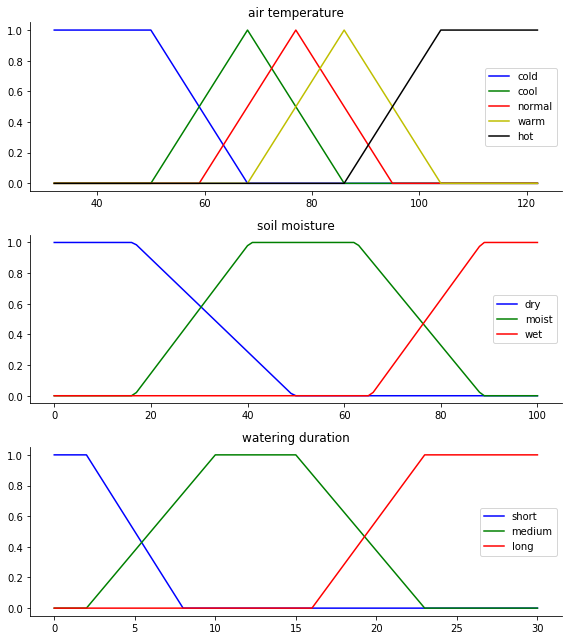

In [17]:
# Visualize these universes and membership functions
fig,(figure1,figure2,figure3)=plt.subplots(nrows=3,figsize=(8,9))

figure1.plot(x_temp_range, temp_cold ,'b',linewidth=1.5,label='cold')
figure1.plot(x_temp_range, temp_cool,'g',linewidth=1.5,label='cool')
figure1.plot(x_temp_range, temp_normal,'r',linewidth=1.5,label='normal')
figure1.plot(x_temp_range, temp_warm,'y',linewidth=1.5,label='warm')
figure1.plot(x_temp_range, temp_hot,'k',linewidth=1.5,label='hot')
figure1.set_title('air temperature')
figure1.legend()

figure2.plot(x_soil_range, soil_dry,'b',linewidth=1.5,label='dry')
figure2.plot(x_soil_range, soil_moist,'g',linewidth=1.5,label='moist')
figure2.plot(x_soil_range, soil_wet,'r',linewidth=1.5,label='wet')
figure2.set_title('soil moisture')
figure2.legend()

figure3.plot(y_time_range, time_short,'b',linewidth=1.5,label='short')
figure3.plot(y_time_range, time_medium,'g',linewidth=1.5,label='medium')
figure3.plot(y_time_range, time_long,'r',linewidth=1.5,label='long')
figure3.set_title('watering duration')
figure3.legend()

# plot 2d figures
for fi in (figure1,figure2,figure3):
  fi.spines['top'].set_visible(False)
  fi.spines['right'].set_visible(False)
  fi.get_xaxis().tick_bottom()
  fi.get_yaxis().tick_left()

plt.tight_layout()



# 3D figure


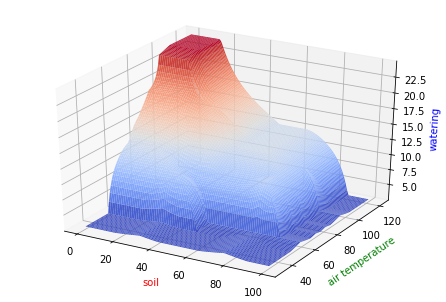

In [7]:
from mpl_toolkits.mplot3d import Axes3D# Required for 3D plotting
def funz(x,y):
  sys_sim.input["temp"] = y
  sys_sim.input["soil"] = x 
  sys_sim.compute()
  z=sys_sim.output["time"]
  return z

fig1=plt.figure()#建立一個繪圖物件
ax=Axes3D(fig1)#用這個繪圖物件建立一個Axes物件(有3D座標)

X,Y=np.meshgrid(x_soil_range,x_temp_range)
Z=funz(X,Y)
ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=plt.cm.coolwarm)#用取樣點(x,y,z)去構建曲面
ax.set_xlabel('soil',color='r')
ax.set_ylabel('air temperature',color='g')
ax.set_zlabel('watering',color='b')#給三個座標軸註明
plt.show()#顯示模組中的所有繪圖物件
